#### GENERATE DATA

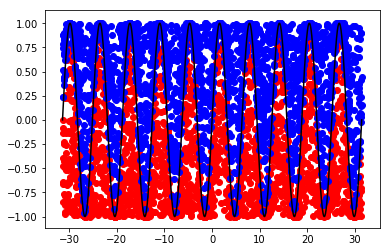

In [1]:
import math
from random import uniform,random
from matplotlib import pyplot as plt
import numpy as np

n_points = int(1e6)
x_min, x_max = -10*math.pi, 10*math.pi
y_min, y_max = -1, 1
X = []
C = []
for i in range(n_points):
    x = uniform(x_min, x_max)
    y_fun = math.sin(x)
    if random() < 0.5 :
        y = uniform(y_min,y_fun)
        c = 0
    else:
        y = uniform(y_fun,y_max)
        c = 1
    X.append([x,y])
    C.append(c)
X = np.array(X)

X0 = []
Y0 = []
X1 = []
Y1 = []

for i in range(5000):
    if C[i] == 0:
        X0.append(X[i][0])
        Y0.append(X[i][1])
    if C[i] == 1:
        X1.append(X[i][0])
        Y1.append(X[i][1])

plt.scatter(X0,Y0, color = 'red')
plt.scatter(X1,Y1, color = 'blue')
x_fun = np.linspace(x_min, x_max,num=1000000)
y_fun = [math.sin(x) for x in x_fun]
plt.plot(x_fun, y_fun, color = 'black')
plt.show()

    
        
    
    

In [2]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() , X[:, 0].max() 
    y_min, y_max = X[:, 1].min() , X[:, 1].max() 
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
            
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    
    plt.scatter(X[:, 0], X[:, 1], c=C, cmap=plt.cm.Spectral)
    plt.show()


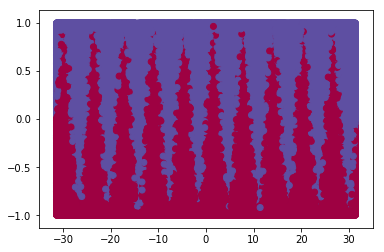

In [3]:
plot_decision_boundary(lambda p : np.array([q[1] > math.sin(q[0]) for q in p]))

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 500)        
        self.fc2 = nn.Linear(500, 256)
        self.rfc2 = nn.Linear(2, 256)
        self.fc3 = nn.Linear(256, 2)
        self.rfc3 = nn.Linear(2, 2)
        
    def forward(self, x):
        x = x.view(-1, 2)
        x_inp = x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x) + self.rfc2(x_inp))
        x = self.fc3(x) + self.rfc3(x_inp)
        return x
    


def train_Net(X,C, ICNN = 'FFN', n_epochs = 10):
    X = np.array(X,dtype=np.float64)
    C = np.array(C,dtype=np.float64)
    num_batches_train = 900
    num_batches_test = 100
    batch_size = 1000
    iter = 0
    n_epochs = n_epochs
    model = MLP()
    ceriation = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
   
    C_pred_col = []
    for epoch in range(n_epochs):
        model.train()
        for iter in tqdm(range(num_batches_train)):
            optimizer.zero_grad()
            x = Variable(torch.from_numpy(X[iter*batch_size:(iter+1)*batch_size]).float())
            c = Variable(torch.from_numpy(C[iter*batch_size:(iter+1)*batch_size]).long())
            x = x.view(batch_size, -1)
            c_pred = model(x)
            loss = ceriation(c_pred,c)
            loss.backward()
            optimizer.step()
            if ICNN == 'FICNN' :
                #model.fc1.weight.data.clamp_(min = 0)
                model.fc2.weight.data.clamp_(min = 0)
                model.fc3.weight.data.clamp_(min = 0)
        print(loss)
        
        model.eval()        
        accuracy = []
        for iter in tqdm(range(num_batches_test)):
            x = Variable(torch.from_numpy(X[iter*batch_size:(iter+1)*batch_size]).float())
            c = C[iter*batch_size:(iter+1)*batch_size]
            x = x.view(batch_size, -1)
            out = model(x)
            out = out.data.numpy().reshape(batch_size,2)
            c_pred = np.apply_along_axis(lambda p : p[1] > p[0], 1, out)
            
            accuracy.append(sum(c_pred == c))
            if epoch == n_epochs - 1:
                C_pred_col = C_pred_col + list(c_pred.reshape(batch_size))
            
            
        print("Epoch : ", epoch, "Val accuracy : ", sum(accuracy)/1e5)

    return C_pred_col, model
            
  
            


In [5]:
#C_pred_col,model = train_Net(X,C)


In [6]:
def predict(model, X_val):
    model.eval()        
    pred = []
    batch_size = 200
    
    num_batches = int(len(X_val)/200)
    for iter in tqdm(range(num_batches)):
        x = Variable(torch.from_numpy(X_val[iter*batch_size:(iter+1)*batch_size]).float())        
        x = x.view(batch_size, -1)
        out = model(x)
        out = out.data.numpy().reshape(batch_size,2)
        c_pred = np.apply_along_axis(lambda p : p[1] > p[0], 1, out)
        pred.append(c_pred)
    return pred
    
    
    
    


In [7]:
#plot_decision_boundary(lambda p : np.array(predict(model, p)))

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:16<00:00, 54.54it/s]


Variable containing:
 0.3938
[torch.FloatTensor of size 1]



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 89.61it/s]


Epoch :  0 Val accuracy :  0.81652


100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:17<00:00, 50.90it/s]


Variable containing:
 0.3918
[torch.FloatTensor of size 1]



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 72.56it/s]


Epoch :  1 Val accuracy :  0.81688


100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:19<00:00, 46.88it/s]


Variable containing:
 0.3915
[torch.FloatTensor of size 1]



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 84.27it/s]


Epoch :  2 Val accuracy :  0.81749


100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:20<00:00, 44.27it/s]


Variable containing:
 0.3912
[torch.FloatTensor of size 1]



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 77.55it/s]


Epoch :  3 Val accuracy :  0.81765


100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:21<00:00, 42.14it/s]


Variable containing:
 0.3910
[torch.FloatTensor of size 1]



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 82.90it/s]


Epoch :  4 Val accuracy :  0.81782


100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:18<00:00, 47.62it/s]


Variable containing:
 0.3909
[torch.FloatTensor of size 1]



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.66it/s]


Epoch :  5 Val accuracy :  0.81792


100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:24<00:00, 37.25it/s]


Variable containing:
 0.3907
[torch.FloatTensor of size 1]



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.47it/s]


Epoch :  6 Val accuracy :  0.81812


100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:21<00:00, 41.53it/s]


Variable containing:
 0.3906
[torch.FloatTensor of size 1]



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 86.95it/s]


Epoch :  7 Val accuracy :  0.81812


100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:19<00:00, 46.37it/s]


Variable containing:
 0.3905
[torch.FloatTensor of size 1]



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 83.55it/s]


Epoch :  8 Val accuracy :  0.81823


100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:18<00:00, 47.59it/s]


Variable containing:
 0.3904
[torch.FloatTensor of size 1]



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 82.57it/s]


Epoch :  9 Val accuracy :  0.81826


100%|█████████████████████████████████████████████████████████████████████████████| 6284/6284 [00:11<00:00, 536.66it/s]


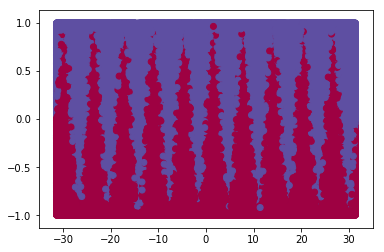

In [8]:
C_pred_col,model_ICNN = train_Net(X,C,ICNN='FICNN')
plot_decision_boundary(lambda p : np.array(predict(model_ICNN, p)))